#### import package

In [1654]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statistics as st 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.compose import make_column_selector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import category_encoders as ce

# EDA

In [1655]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [1656]:
df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])
# test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]

## Pre-processing

#### planning_area & subzone NA value in test dataset

In [1657]:
emptyPA = test[test['planning_area'].isna()]
emptyPA['address'].unique()

array(['1 tessensohn road', '38 lorong 32 geylang', '17 farrer drive',
       '5 jalan mutiara'], dtype=object)

In [1658]:
missingPA = pd.read_csv('auxiliary-data/missingPAdata.csv')
missingPA.head()

,address,planning_area,subzone
0,1 tessensohn road,kallang,boon keng
1,38 lorong 32 geylang,geylang,aljunied
2,15 farrer drive,tanglin,chatsworth
3,17 farrer drive,tanglin,chatsworth
4,5 jalan mutiara,tanglin,nassim


In [1659]:
s = missingPA.set_index('address')['planning_area']
df['planning_area']=df['planning_area'].fillna(df['address'].map(s))

In [1660]:
s = missingPA.set_index('address')['subzone']
df['subzone']=df['planning_area'].fillna(df['subzone'].map(s))

In [1661]:
df.count()

listing_id              27220
title                   27220
address                 27218
property_name           27220
property_type           27220
tenure                  24860
built_year              25940
num_beds                27105
num_baths               26637
size_sqft               27220
floor_level              4664
furnishing              27220
available_unit_types    25259
total_num_units         19668
property_details_url    27220
lat                     27220
lng                     27220
elevation               27220
subzone                 27220
planning_area           27220
ind                     27220
price                   20254
dtype: int64

### Remove listing_id  
#### listing_id is all unique without duplicates

In [1662]:
# train = train.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])
# test = test.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])

df = df.drop(columns=['floor_level','listing_id', 'property_details_url', 'elevation','property_name','address','title'])

# train = train.drop(columns=['property_details_url', 'elevation','property_name','address','title'])

### Adding Distances

#### CC_center

In [1663]:
ccdistance = pd.read_csv('auxiliary-data/sg-commerical-centres.csv')

In [1664]:
# vectorized haversine function
#https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


In [1665]:
expected_result = pd.merge(test, ccdistance, on = 'planning_area')
df['cc_distance'] = haversine_np(expected_result['lng_x'], expected_result['lat_x'], expected_result['lng_y'], expected_result['lat_y'])
df.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,lng,subzone,planning_area,ind,price,cc_distance
0,condo,freehold,2022.0,1.0,1.0,463,unfurnished,"studio, 1, 2, 3, 4, 5 br",250.0,1.344334,103.878690,serangoon,serangoon,test,NaN,1.046868
1,Condo,99-year leasehold,2017.0,3.0,3.0,1033,unspecified,"studio, 1, 2, 3, 4, 5 br",463.0,1.380281,103.943878,pasir ris,pasir ris,test,NaN,1.284121
2,condo,99-year leasehold,2007.0,1.0,1.0,570,fully,"studio, 1, 2, 3 br",646.0,1.294668,103.850074,museum,museum,test,NaN,0.500575
3,Hdb,99-year leasehold,2017.0,3.0,2.0,1216,unspecified,"1, 2, 3, 4, 5 br",968.0,1.373120,103.746094,choa chu kang,choa chu kang,test,NaN,1.046868
4,hdb 4 rooms,99-year leasehold,1973.0,3.0,2.0,936,unspecified,"1, 2, 3, 4 br",NaN,1.341468,103.849047,toa payoh,toa payoh,test,NaN,1.046868


In [1666]:
df['cc_distance'].fillna(0,inplace=True)

In [1667]:
df.loc[df['cc_distance'] !=0, 'cc_distance'] = 1

#### Add distance to mrt stations

In [1668]:
# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(test, mrtdistance, on = 'planning_area')
df['mrt_distance'] = haversine_np(expected_result['lng_x'], expected_result['lat_x'], expected_result['lng_y'], expected_result['lat_y'])
df.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,lng,subzone,planning_area,ind,price,cc_distance,mrt_distance
0,condo,freehold,2022.0,1.0,1.0,463,unfurnished,"studio, 1, 2, 3, 4, 5 br",250.0,1.344334,103.878690,serangoon,serangoon,test,NaN,1.0,0.960436
1,Condo,99-year leasehold,2017.0,3.0,3.0,1033,unspecified,"studio, 1, 2, 3, 4, 5 br",463.0,1.380281,103.943878,pasir ris,pasir ris,test,NaN,1.0,1.736900
2,condo,99-year leasehold,2007.0,1.0,1.0,570,fully,"studio, 1, 2, 3 br",646.0,1.294668,103.850074,museum,museum,test,NaN,1.0,0.960436
3,Hdb,99-year leasehold,2017.0,3.0,2.0,1216,unspecified,"1, 2, 3, 4, 5 br",968.0,1.373120,103.746094,choa chu kang,choa chu kang,test,NaN,1.0,1.369843
4,hdb 4 rooms,99-year leasehold,1973.0,3.0,2.0,936,unspecified,"1, 2, 3, 4 br",NaN,1.341468,103.849047,toa payoh,toa payoh,test,NaN,1.0,1.126905


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mrt_distance'>

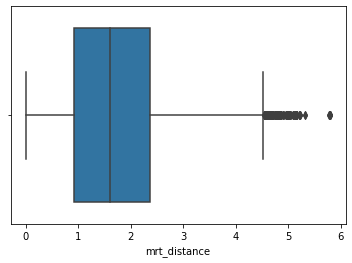

In [1669]:
sns.boxplot(df['mrt_distance'])

#### Add distance to primary school 

In [1670]:
# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(test, primaryschooldistance, on = 'planning_area')
df['primary_school_distance'] = haversine_np(expected_result['lng_x'], expected_result['lat_x'], expected_result['lng_y'], expected_result['lat_y'])
df.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,lng,subzone,planning_area,ind,price,cc_distance,mrt_distance,primary_school_distance
0,condo,freehold,2022.0,1.0,1.0,463,unfurnished,"studio, 1, 2, 3, 4, 5 br",250.0,1.344334,103.878690,serangoon,serangoon,test,NaN,1.0,0.960436,13.993735
1,Condo,99-year leasehold,2017.0,3.0,3.0,1033,unspecified,"studio, 1, 2, 3, 4, 5 br",463.0,1.380281,103.943878,pasir ris,pasir ris,test,NaN,1.0,1.736900,11.182232
2,condo,99-year leasehold,2007.0,1.0,1.0,570,fully,"studio, 1, 2, 3 br",646.0,1.294668,103.850074,museum,museum,test,NaN,1.0,0.960436,4.148719
3,Hdb,99-year leasehold,2017.0,3.0,2.0,1216,unspecified,"1, 2, 3, 4, 5 br",968.0,1.373120,103.746094,choa chu kang,choa chu kang,test,NaN,1.0,1.369843,8.460539
4,hdb 4 rooms,99-year leasehold,1973.0,3.0,2.0,936,unspecified,"1, 2, 3, 4 br",NaN,1.341468,103.849047,toa payoh,toa payoh,test,NaN,1.0,1.126905,5.206584


#### Add distance to secondary school

In [1671]:
# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
df['secondary_school_distance'] = haversine_np(expected_result['lng_x'], expected_result['lat_x'], expected_result['lng_y'], expected_result['lat_y'])
df.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,lng,subzone,planning_area,ind,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance
0,condo,freehold,2022.0,1.0,1.0,463,unfurnished,"studio, 1, 2, 3, 4, 5 br",250.0,1.344334,103.878690,serangoon,serangoon,test,NaN,1.0,0.960436,13.993735,1.853769
1,Condo,99-year leasehold,2017.0,3.0,3.0,1033,unspecified,"studio, 1, 2, 3, 4, 5 br",463.0,1.380281,103.943878,pasir ris,pasir ris,test,NaN,1.0,1.736900,11.182232,3.014111
2,condo,99-year leasehold,2007.0,1.0,1.0,570,fully,"studio, 1, 2, 3 br",646.0,1.294668,103.850074,museum,museum,test,NaN,1.0,0.960436,4.148719,0.455365
3,Hdb,99-year leasehold,2017.0,3.0,2.0,1216,unspecified,"1, 2, 3, 4, 5 br",968.0,1.373120,103.746094,choa chu kang,choa chu kang,test,NaN,1.0,1.369843,8.460539,1.138964
4,hdb 4 rooms,99-year leasehold,1973.0,3.0,2.0,936,unspecified,"1, 2, 3, 4 br",NaN,1.341468,103.849047,toa payoh,toa payoh,test,NaN,1.0,1.126905,5.206584,0.499738


#### Add distance to shopping malls

In [1672]:
# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(test, shop_distance, on = 'planning_area')
df['shop_distance'] = haversine_np(expected_result['lng_x'], expected_result['lat_x'], expected_result['lng_y'], expected_result['lat_y'])
df.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,lng,subzone,planning_area,ind,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance
0,condo,freehold,2022.0,1.0,1.0,463,unfurnished,"studio, 1, 2, 3, 4, 5 br",250.0,1.344334,103.878690,serangoon,serangoon,test,NaN,1.0,0.960436,13.993735,1.853769,0.987277
1,Condo,99-year leasehold,2017.0,3.0,3.0,1033,unspecified,"studio, 1, 2, 3, 4, 5 br",463.0,1.380281,103.943878,pasir ris,pasir ris,test,NaN,1.0,1.736900,11.182232,3.014111,4.906856
2,condo,99-year leasehold,2007.0,1.0,1.0,570,fully,"studio, 1, 2, 3 br",646.0,1.294668,103.850074,museum,museum,test,NaN,1.0,0.960436,4.148719,0.455365,2.765780
3,Hdb,99-year leasehold,2017.0,3.0,2.0,1216,unspecified,"1, 2, 3, 4, 5 br",968.0,1.373120,103.746094,choa chu kang,choa chu kang,test,NaN,1.0,1.369843,8.460539,1.138964,1.361122
4,hdb 4 rooms,99-year leasehold,1973.0,3.0,2.0,936,unspecified,"1, 2, 3, 4 br",NaN,1.341468,103.849047,toa payoh,toa payoh,test,NaN,1.0,1.126905,5.206584,0.499738,2.907287


### lng & lat

In [1673]:
df = df.drop(columns=['lat','lng'])

### Population

In [1674]:
population = pd.read_csv('auxiliary-data/sg-subzones.csv')

In [1675]:
expected_result = pd.merge(df, population, on = 'planning_area')
df['population'] = expected_result['population']
df['area_size'] = expected_result['area_size']

### Property Type cleaning

In [1676]:
#Change all to uppercase
df['property_type']=df['property_type'].str.upper()


In [1677]:
df['property_type'].unique()

array(['CONDO', 'HDB', 'HDB 4 ROOMS', 'TERRACED HOUSE', 'HDB 5 ROOMS',
       'HDB 3 ROOMS', 'SEMI-DETACHED HOUSE', 'EXECUTIVE CONDO',
       'BUNGALOW', 'HDB EXECUTIVE', 'HDB 2 ROOMS', 'APARTMENT',
       'CLUSTER HOUSE', 'CORNER TERRACE', 'WALK-UP', 'CONSERVATION HOUSE',
       'LANDED', 'TOWNHOUSE', 'GOOD CLASS BUNGALOW', 'LAND ONLY',
       'SHOPHOUSE'], dtype=object)

In [1678]:
df['property_type'] = df['property_type'].replace(
    ['CLUSTER HOUSE', 'CONSERVATION HOUSE', 'LANDED', 'WALK-UP', 'TOWNHOUSE', 'GOOD CLASS BUNGALOW', 'CORNER TERRACE', 'SEMI-DETACHED HOUSE', 'BUNGALOW', 'TERRACED HOUSE','SHOPHOUSE','LAND ONLY'],
    'LANDED'
)

In [1679]:
df['property_type'] = df['property_type'].replace(
    ['HDB 3 ROOMS', 'HDB 4 ROOMS', 'HDB 5 ROOMS', 'HDB 2 ROOMS'],
    'HDB'
)

In [1680]:
df['property_type'] = df['property_type'].replace(
    ['APARTMENT'],
    'CONDO'
)

In [1681]:
df['property_type'].unique()

array(['CONDO', 'HDB', 'LANDED', 'EXECUTIVE CONDO', 'HDB EXECUTIVE'],
      dtype=object)

In [1682]:
condo = df[df['property_type'] == 'CONDO']
hdb = df[df['property_type'] == 'HDB']
landed = df[df['property_type'] == 'LANDED']
Econdo = df[df['property_type'] == 'EXECUTIVE CONDO']
Ehdb = df[df['property_type'] == 'HDB EXECUTIVE']

### Distance Cleaning

<AxesSubplot:xlabel='mrt_distance', ylabel='property_type'>

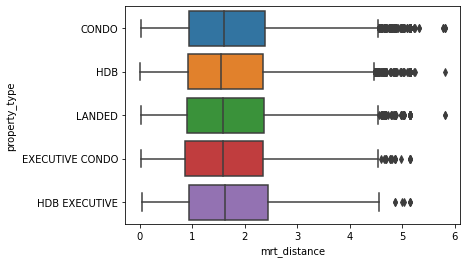

In [1683]:
sns.boxplot(x = df['mrt_distance'], y = df['property_type'])

In [1684]:
condoQ1, condoQ3 = np.percentile(condo['mrt_distance'] , [1,94])
hdbQ1, hdbQ3 = np.percentile(hdb['mrt_distance'] , [1,94])
landQ1, landQ3 = np.percentile(landed['mrt_distance'] , [1,94])
EhdbQ1, EhdbQ3 = np.percentile(hdb['mrt_distance'] , [1,95])
EcondoQ1, EcondoQ3 = np.percentile(condo['mrt_distance'] , [1,94])

In [1685]:
condo['mrt_distance'].median()

1.6109448127938346

In [1686]:

df.loc[(df['property_type'] == 'CONDO') & (df['mrt_distance'] > condoQ3), 'mrt_distance'] = condo['mrt_distance'].median()
df.loc[(df['property_type'] == 'HDB') & (df['mrt_distance'] > hdbQ3), 'mrt_distance'] = hdb['mrt_distance'].median()

df.loc[(df['property_type'] == 'LANDED') & (df['mrt_distance'] > landQ3), 'mrt_distance'] = landed['mrt_distance'].median()


df.loc[(df['property_type'] == 'EXECUTIVE CONDO') & (df['mrt_distance'] > EcondoQ3), 'mrt_distance'] = Econdo['mrt_distance'].median()

df.loc[(df['property_type'] == 'HDB EXECUTIVE') & (df['mrt_distance'] > EhdbQ3), 'mrt_distance'] = Ehdb['mrt_distance'].median()

<AxesSubplot:xlabel='mrt_distance', ylabel='property_type'>

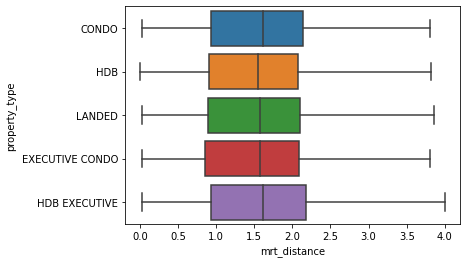

In [1687]:
sns.boxplot(x = df['mrt_distance'], y = df['property_type'])

<AxesSubplot:xlabel='primary_school_distance', ylabel='property_type'>

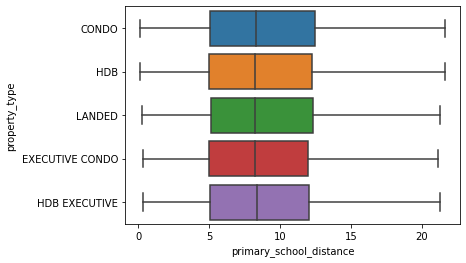

In [1688]:
sns.boxplot(x = df['primary_school_distance'], y = df['property_type'])

<AxesSubplot:xlabel='secondary_school_distance', ylabel='property_type'>

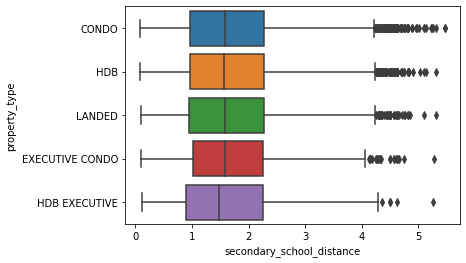

In [1689]:
sns.boxplot(x=df['secondary_school_distance'],y=df['property_type'])

In [1690]:
condoQ1, condoQ3 = np.percentile(condo['secondary_school_distance'] , [1,98])
hdbQ1, hdbQ3 = np.percentile(hdb['secondary_school_distance'] , [1,98])
landQ1, landQ3 = np.percentile(landed['secondary_school_distance'] , [1,98])
EhdbQ1, EhdbQ3 = np.percentile(hdb['secondary_school_distance'] , [1,98])
EcondoQ1, EcondoQ3 = np.percentile(condo['secondary_school_distance'] , [1,97])

<AxesSubplot:xlabel='secondary_school_distance', ylabel='property_type'>

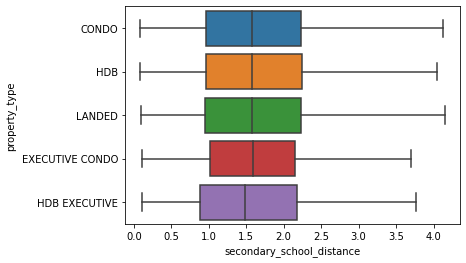

In [1691]:

df.loc[(df['property_type'] == 'CONDO') & (df['secondary_school_distance'] > condoQ3), 'secondary_school_distance'] = condo['secondary_school_distance'].median()
df.loc[(df['property_type'] == 'HDB') & (df['secondary_school_distance'] > hdbQ3), 'secondary_school_distance'] = hdb['secondary_school_distance'].median()

df.loc[(df['property_type'] == 'LANDED') & (df['secondary_school_distance'] > landQ3), 'secondary_school_distance'] = landed['secondary_school_distance'].median()


df.loc[(df['property_type'] == 'EXECUTIVE CONDO') & (df['secondary_school_distance'] > EcondoQ3), 'secondary_school_distance'] = Econdo['secondary_school_distance'].median()

df.loc[(df['property_type'] == 'HDB EXECUTIVE') & (df['secondary_school_distance'] > EhdbQ3), 'secondary_school_distance'] = Ehdb['secondary_school_distance'].median()
sns.boxplot(x=df['secondary_school_distance'],y=df['property_type'])

<AxesSubplot:xlabel='shop_distance', ylabel='property_type'>

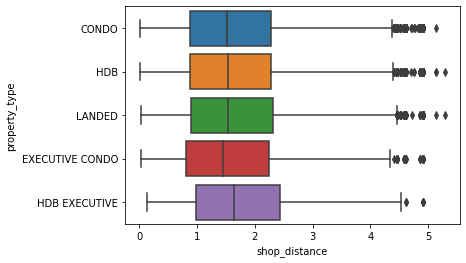

In [1692]:
sns.boxplot(x = df['shop_distance'], y = df['property_type'])

In [1693]:
condoQ1, condoQ3 = np.percentile(condo['shop_distance'] , [1,96])
hdbQ1, hdbQ3 = np.percentile(hdb['shop_distance'] , [1,96])
landQ1, landQ3 = np.percentile(landed['shop_distance'] , [1,96])

EhdbQ1, EhdbQ3 = np.percentile(hdb['shop_distance'] , [1,97])#
EcondoQ1, EcondoQ3 = np.percentile(condo['shop_distance'] , [1,96])

<AxesSubplot:xlabel='shop_distance', ylabel='property_type'>

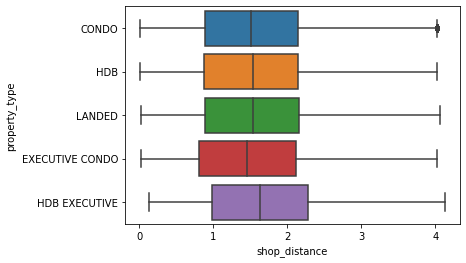

In [1694]:

df.loc[(df['property_type'] == 'CONDO') & (df['shop_distance'] > condoQ3), 'shop_distance'] = condo['shop_distance'].median()
df.loc[(df['property_type'] == 'HDB') & (df['shop_distance'] > hdbQ3), 'shop_distance'] = hdb['shop_distance'].median()

df.loc[(df['property_type'] == 'LANDED') & (df['shop_distance'] > landQ3), 'shop_distance'] = landed['shop_distance'].median()


df.loc[(df['property_type'] == 'EXECUTIVE CONDO') & (df['shop_distance'] > EcondoQ3), 'shop_distance'] = Econdo['shop_distance'].median()

df.loc[(df['property_type'] == 'HDB EXECUTIVE') & (df['shop_distance'] > EhdbQ3), 'shop_distance'] = Ehdb['shop_distance'].median()
sns.boxplot(x=df['shop_distance'],y=df['property_type'])

### Tenure 

In [1695]:
df['tenure'] = df['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

df['tenure'] = df['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    '999-year leasehold'
    ],
    '999-year leasehold'
)

In [1696]:
df['tenure'] = df['tenure'].fillna('99-year leasehold')

In [1697]:
df['tenure'].unique()

array(['freehold', '99-year leasehold', '999-year leasehold'],
      dtype=object)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tenure', ylabel='count'>

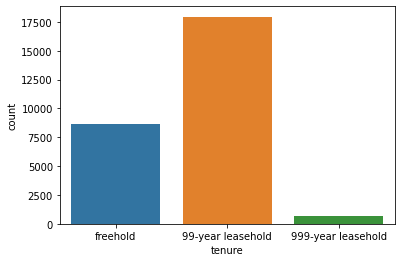

In [1698]:
sns.countplot(df['tenure'])

### Funishing

In [1699]:
#Assume not specified and na as unfurnished 
df['furnishing'] = df['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='furnishing', ylabel='count'>

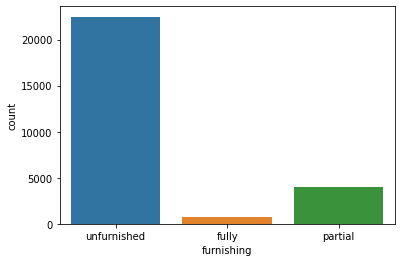

In [1700]:
sns.countplot(df['furnishing'])

In [1701]:
# #Assume not specified and na as unfurnished 
# train['furnishing'] = train['furnishing'].replace(
#     [
#     'fully',
#     ],
#     'partial'
# )

# #Assume not specified and na as unfurnished 
# test['furnishing'] = test['furnishing'].replace(
#     [
#     'fully',
#     ],
#     'partial'
# )

### total_num_units

In [1702]:
condomedium = condo['total_num_units'].median()
hdbmedium = hdb['total_num_units'].median()
landmedium = landed['total_num_units'].median()
Econdomedium = Econdo['total_num_units'].median()
Ehdbmedium = Ehdb['total_num_units'].median()


In [1703]:
df.loc[df.property_type == 'CONDO', 'total_num_units'] = condomedium
df.loc[df.property_type == 'HDB', 'total_num_units'] = hdbmedium
df.loc[df.property_type == 'LANDED', 'total_num_units'] = landmedium
df.loc[df.property_type == 'EXECUTIVE CONDO', 'total_num_units'] = Econdomedium
df.loc[df.property_type == 'HDB EXECUTIVE', 'total_num_units'] = Ehdbmedium

<AxesSubplot:xlabel='total_num_units', ylabel='property_type'>

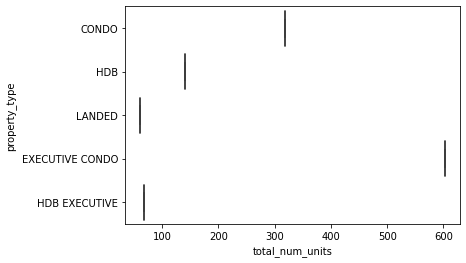

In [1704]:
sns.boxplot(x=df['total_num_units'], y=df['property_type'])

### build year

In [1705]:
condomedium = condo['built_year'].median()
hdbmedium = hdb['built_year'].median()
landmedium = landed['built_year'].median()
Econdomedium = Econdo['built_year'].median()
Ehdbmedium = Ehdb['built_year'].median()


In [1706]:
df.loc[df.property_type == 'CONDO', 'built_year'] = condomedium
df.loc[df.property_type == 'HDB', 'built_year'] = hdbmedium
df.loc[df.property_type == 'LANDED', 'built_year'] = landmedium
df.loc[df.property_type == 'EXECUTIVE CONDO', 'built_year'] = Econdomedium
df.loc[df.property_type == 'HDB EXECUTIVE', 'built_year'] = Ehdbmedium


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='built_year'>

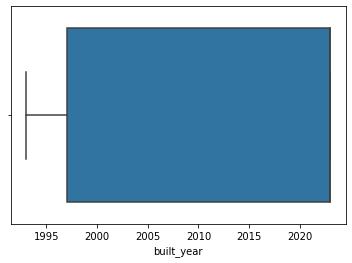

In [1707]:
sns.boxplot(df['built_year'])

### num_baths

In [1708]:
condomedium = condo['num_baths'].median()
hdbmedium = hdb['num_baths'].median()
landmedium = landed['num_baths'].median()
Econdomedium = Econdo['num_baths'].median()
Ehdbmedium = Ehdb['num_baths'].median()

In [1709]:
df.loc[df.property_type == 'CONDO', 'num_baths'] = condomedium
df.loc[df.property_type == 'HDB', 'num_baths'] = hdbmedium
df.loc[df.property_type == 'LANDED', 'num_baths'] = landmedium
df.loc[df.property_type == 'EXECUTIVE CONDO', 'num_baths'] = Econdomedium
df.loc[df.property_type == 'HDB EXECUTIVE', 'num_baths'] = Ehdbmedium

### num_beds

In [1710]:
condomedium = condo['num_beds'].median()
hdbmedium = hdb['num_beds'].median()
landmedium = landed['num_beds'].median()
Econdomedium = Econdo['num_beds'].median()
Ehdbmedium = Ehdb['num_beds'].median()

In [1711]:
df.loc[df.property_type == 'CONDO', 'num_beds'] = condomedium
df.loc[df.property_type == 'HDB', 'num_beds'] = hdbmedium
df.loc[df.property_type == 'LANDED', 'num_beds'] = landmedium
df.loc[df.property_type == 'EXECUTIVE CONDO', 'num_beds'] = Econdomedium
df.loc[df.property_type == 'HDB EXECUTIVE', 'num_beds'] = Ehdbmedium

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_beds', ylabel='count'>

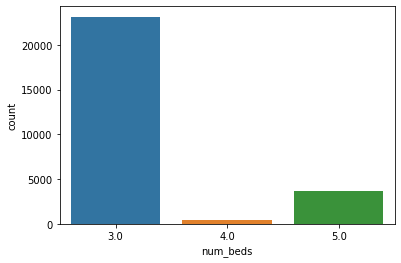

In [1712]:
sns.countplot(df['num_beds'])

### num_avaliable_units

In [1713]:
numavaunittypes = df.available_unit_types.str.count(',') + 1
df['available_unit_types'] = numavaunittypes

In [1714]:
condo = df[df['property_type'] == 'CONDO']
hdb = df[df['property_type'] == 'HDB']
landed = df[df['property_type'] == 'LANDED']
Econdo = df[df['property_type'] == 'EXECUTIVE CONDO']
Ehdb = df[df['property_type'] == 'HDB EXECUTIVE']

df.loc[df.property_type == 'CONDO', 'available_unit_types'] = condomedium
df.loc[df.property_type == 'HDB', 'available_unit_types'] = hdbmedium
df.loc[df.property_type == 'LANDED', 'available_unit_types'] = landmedium
df.loc[df.property_type == 'EXECUTIVE CONDO', 'available_unit_types'] = Econdomedium
df.loc[df.property_type == 'HDB EXECUTIVE', 'available_unit_types'] = Ehdbmedium

<AxesSubplot:xlabel='available_unit_types', ylabel='count'>

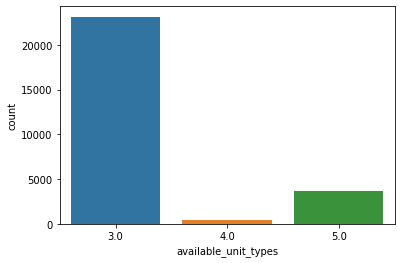

In [1715]:
sns.countplot(x = df['available_unit_types'])

### price 

Remove price which is 0

In [1716]:
df = df[df['price'] != 0]

In [1717]:
df['log_price'] = np.log(df['price'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price', ylabel='property_type'>

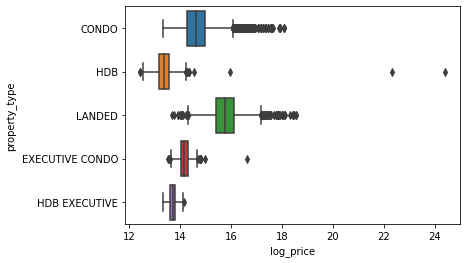

In [1718]:
sns.boxplot(df['log_price'], y = df['property_type'])

### subzone and planning_area

In [1719]:
# adding regions
central = ['bishan', 'bukit merah', 'bukit timah', 'downtown core', 'geylang', 'kallang', 'marina east', 'marina south', 'marine parade', 'museum', 'newton',
           'novena', 'orchard', 'outram', 'queenstown', 'river valley', 'rochor', 'singapore river', 'southern islands', 'straits view', 'tanglin', 'toa payoh']

east = [ 'bedok', 'changi', 'changi bay', 'pasir ris', 'paya lebar', 'tampines']

north = ['central water catchment', 'lim chu kang', 'mandai', 'sembawang', 'simpang', 'sungei kadut', 'woodlands', 'yishun']

north_east = ['ang mo kio', 'hougang', 'north-eastern islands', 'punggol', 'seletar', 'sengkang', 'serangoon']

west = ['boon lay', 'bukit batok', 'bukit panjang', 'choa chu kang', 'clementi', 'jurong east', 'jurong west', 'pioneer', 'tengah', 'tuas', 'western islands', 'western water catchment']

In [1720]:
df['region'] = df['subzone'].copy()

In [1721]:
df['region'] = df['region'].replace(
    central,
    'central'
)

df['region'] = df['region'].replace(
    east,
    'east'
)

df['region'] = df['region'].replace(
    north,
    'north'
)

df['region'] = df['region'].replace(
    north_east,
    'north_east'
)

df['region'] = df['region'].replace(
    west,
    'west'
)

In [1722]:
df.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,...,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,log_price,region
0,CONDO,freehold,2023.0,3.0,2.0,463,unfurnished,3.0,319.0,serangoon,...,NaN,1.0,0.960436,13.993735,1.853769,0.987277,8490,1.1801,NaN,north_east
1,CONDO,99-year leasehold,2023.0,3.0,2.0,1033,unfurnished,3.0,319.0,pasir ris,...,NaN,1.0,1.736900,11.182232,3.014111,1.514959,14700,2.3307,NaN,east
2,CONDO,99-year leasehold,2023.0,3.0,2.0,570,fully,3.0,319.0,museum,...,NaN,1.0,0.960436,4.148719,0.455365,2.765780,24760,1.0619,NaN,central
3,HDB,99-year leasehold,1997.0,3.0,2.0,1216,unfurnished,3.0,140.0,choa chu kang,...,NaN,1.0,1.369843,8.460539,1.138964,1.361122,36080,3.0232,NaN,west
4,HDB,99-year leasehold,1997.0,3.0,2.0,936,unfurnished,3.0,140.0,toa payoh,...,NaN,1.0,1.126905,5.206584,0.499738,2.907287,15940,0.6847,NaN,central


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='region', ylabel='count'>

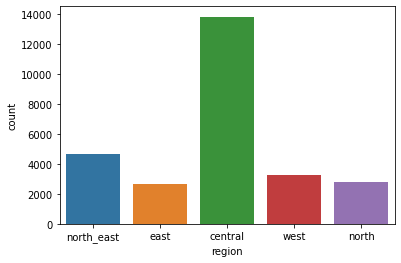

In [1723]:
sns.countplot(df['region'])

### Remove Redundant features

In [1724]:
df.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
size_sqft                      int64
furnishing                    object
available_unit_types         float64
total_num_units              float64
subzone                       object
planning_area                 object
ind                           object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
log_price                    float64
region                        object
dtype: object

In [1725]:
df = df.drop(columns=['subzone','planning_area'])

#### Separate into Test and Train

In [1726]:
test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]
train = train.drop(columns=['ind'])
test = test.drop(columns=['ind','price','log_price'])

In [1727]:
train.count()

property_type                20153
tenure                       20153
built_year                   20153
num_beds                     20153
num_baths                    20153
size_sqft                    20153
furnishing                   20153
available_unit_types         20153
total_num_units              20153
price                        20153
cc_distance                  20153
mrt_distance                 20153
primary_school_distance      20153
secondary_school_distance    20153
shop_distance                20153
population                   20153
area_size                    20153
log_price                    20153
region                       20153
dtype: int64

In [1728]:
test.count()

property_type                6966
tenure                       6966
built_year                   6966
num_beds                     6966
num_baths                    6966
size_sqft                    6966
furnishing                   6966
available_unit_types         6966
total_num_units              6966
cc_distance                  6966
mrt_distance                 6966
primary_school_distance      6966
secondary_school_distance    6966
shop_distance                6966
population                   6966
area_size                    6966
region                       6966
dtype: int64

# Outlier Detection

In [1729]:
# from collections import Counter
# from datetime import datetime
# dates_dict = {
#     'B_birthday': '%Y-%m-%d', 
#     'B_dtopentime': '%Y-%m-%d %H:%M:%S'
# }
# from pandas.api.types import is_string_dtype
# from pandas.api.types import is_numeric_dtype
# import os,re

# dummy_list = []
# bools = []
# numerics = []
# strings = []

# def plot_lineplot(df, i, rotation=None, width=6, height=3.5, save=False, convert=False):
#     if convert:
#         df[i] = df[i].applymap(lambda x: re.sub('[^0-9]', '', x))
#     x = df[i].dropna()
#     nums = dict(Counter(x))
#     nums_df = pd.DataFrame({
#         i: list(nums.keys()),
#         'count': list(nums.values())
#     })
#     sns.set(rc={'figure.figsize':(width, height)})
#     ax = sns.lineplot(data=nums_df, x=i, y='count')
#     ax.set_title(f'Lineplot of {i}')
#     if rotation is not None:
#         plt.xticks(rotation=rotation)
#     plt.tight_layout()
#     if save: plt.savefig(f'figs/eda_{i}_lineplot', bbox_inches = "tight")
#     plt.show()
    
# def plot_numeric(df, i, save=False):
#     x = df[i]
#     sns.set(rc={'figure.figsize':(6,1)})
#     ax = sns.boxplot(x, color='lightblue')
#     ax.set_title(f'Boxplot of {i}')
#     plt.tight_layout()
#     if save: plt.savefig(f'figs/eda_{i}_boxplot', bbox_inches = "tight")
#     plt.show()
    
# def plot_categorical(df, i, top_k=None, save=False):
#     x = df[i]
#     total = float(len(x))
#     if top_k is None:
#         n_cates = len(set(x))
#     else:
#         n_cates=top_k
#     sns.set(rc={'figure.figsize':(6, n_cates/8+2)})
#     sns.set(font="SimSun")
#     ax = sns.countplot(y=x, color="lightblue", dodge=False, order = x.value_counts().iloc[:n_cates].index)
#     for p in ax.patches:
#         percentage = f'{100 * p.get_width() / total:.1f}%\n'
#         x = p.get_width()
#         y = p.get_y() + p.get_height() / 2
#         ax.annotate(percentage, (x, y), ha='right', va='center')
#     ax.set_title(f'Countplot of {i}')
#     plt.tight_layout()
#     if save: plt.savefig(f'figs/eda_{i}_countplot', bbox_inches = "tight")
#     plt.show()
        
# def plot_dates(df, i, save=False):
#     x = df[i].dropna().apply(lambda d: datetime.strptime(d, dates_dict[i]))
#     dates = dict(Counter(x))
#     dates_df = pd.DataFrame({
#         'date': list(dates.keys()),
#         'count': list(dates.values())
#     })
#     sns.set(rc={'figure.figsize':(6,3.5)})
#     ax = sns.lineplot(data=dates_df, x='date', y='count')
#     ax.set_title(f'Lineplot of {i}')
#     plt.tight_layout()
#     if save: plt.savefig(f'figs/eda_{i}_lineplot', bbox_inches = "tight")
#     plt.show()
    
# def plot_all(df, top_k=None, save=False, num_string_pattern = '\d{4}\-\d{2}'):
#     for i in df.columns:
#         _df = df.dropna(subset=[i])
#         if len(df)!=len(_df):
#             print(f'Plot for "{i}" (Missing {len(df)-len(_df)} items...)')
#         else:
#             print(f'Plot for "{i}"')
#         if is_numeric_dtype(df[i]):
#             if len(set(_df))==2:
#                 bools.append(i, save=save)
#                 plot_categorical(_df, i, top_k=top_k, save=save)
#             else:
#                 numerics.append(i)
#                 plot_numeric(_df, i, save=save)
#                 if i in dummy_list:
#                     plot_categorical(_df, i, top_k=top_k, save=save)
#         else:
#             if i in dates_dict.keys():
#                 plot_dates(_df, i, save=save)
#             elif all([bool(re.match(num_string_pattern, s)) for s in _df[i]]):
#                 # this matches Year-Month format of YYYY-MM (can custom pattern, or by |)
#                 plot_lineplot(_df, i, rotation=90, height=3.5, width=len(df[i].unique())/7.2, save=save)
#             else:
#                 strings.append(i)
#                 plot_categorical(_df, i, save=save)
    
#     print(f'----- auto eda summary -----')
#     print(f'identified bools: {bools}')
#     print(f'identified numerics: {numerics}')
#     print(f'identified strings: {strings}')
#     print(f'cols to fix: {list(train.columns.difference(bools+numerics+strings))}')
           
# plot_all(train, save=False)

In [1730]:
train.count()

property_type                20153
tenure                       20153
built_year                   20153
num_beds                     20153
num_baths                    20153
size_sqft                    20153
furnishing                   20153
available_unit_types         20153
total_num_units              20153
price                        20153
cc_distance                  20153
mrt_distance                 20153
primary_school_distance      20153
secondary_school_distance    20153
shop_distance                20153
population                   20153
area_size                    20153
log_price                    20153
region                       20153
dtype: int64

In [1731]:
train = train[train['size_sqft']!=0]

In [1732]:
train.count()

property_type                20153
tenure                       20153
built_year                   20153
num_beds                     20153
num_baths                    20153
size_sqft                    20153
furnishing                   20153
available_unit_types         20153
total_num_units              20153
price                        20153
cc_distance                  20153
mrt_distance                 20153
primary_school_distance      20153
secondary_school_distance    20153
shop_distance                20153
population                   20153
area_size                    20153
log_price                    20153
region                       20153
dtype: int64

In [1733]:
train['psqft'] = train['price']/train['size_sqft']

In [1734]:
train['log_psqft'] =np.log(train['psqft'])

<AxesSubplot:xlabel='log_psqft', ylabel='property_type'>

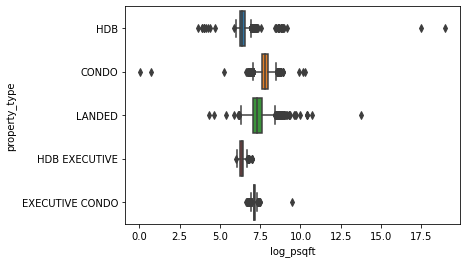

In [1735]:
sns.boxplot(x = train['log_psqft'],y=train['property_type'])

In [1736]:
condo = train[train['property_type'] == 'CONDO']
hdb = train[train['property_type'] == 'HDB']
landed = train[train['property_type'] == 'LANDED']
Econdo = train[train['property_type'] == 'EXECUTIVE CONDO']
Ehdb = train[train['property_type'] == 'HDB EXECUTIVE']

In [1737]:
condoQ1, condoQ3 = np.percentile(condo['log_psqft'] , [3,95])
hdbQ1, hdbQ3 = np.percentile(hdb['log_psqft'] , [1,87])
landQ1, landQ3 = np.percentile(landed['log_psqft'] , [1,96])

EhdbQ1, EhdbQ3 = np.percentile(hdb['log_psqft'] , [1,83])
EcondoQ1, EcondoQ3 = np.percentile(condo['log_psqft'] , [2,5])

In [1738]:
EcondoQ3

7.2578617068791536

<AxesSubplot:xlabel='log_psqft', ylabel='property_type'>

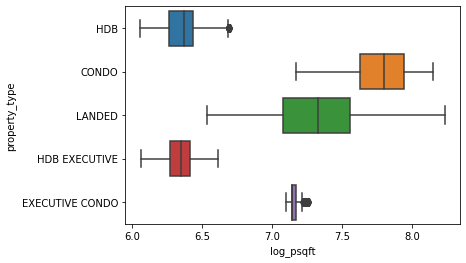

In [1739]:
train.loc[(train['property_type'] == 'CONDO') & (train['log_psqft'] < condoQ1), 'log_psqft'] = condo['log_psqft'].median()
train.loc[(train['property_type'] == 'CONDO') & (train['log_psqft'] > condoQ3), 'log_psqft'] = condo['log_psqft'].median()

train.loc[(train['property_type'] == 'HDB') & (train['log_psqft'] < hdbQ1), 'log_psqft'] = hdb['log_psqft'].median()
train.loc[(train['property_type'] == 'HDB') & (train['log_psqft'] > hdbQ3), 'log_psqft'] = hdb['log_psqft'].median()

train.loc[(train['property_type'] == 'LANDED') & (train['log_psqft'] < landQ1), 'log_psqft'] = landed['log_psqft'].median()
train.loc[(train['property_type'] == 'LANDED') & (train['log_psqft'] > landQ3), 'log_psqft'] = landed['log_psqft'].median()

train.loc[(train['property_type'] == 'EXECUTIVE CONDO') & (train['log_psqft'] < EcondoQ1), 'log_psqft'] = Econdo['log_psqft'].median()
train.loc[(train['property_type'] == 'EXECUTIVE CONDO') & (train['log_psqft'] > EcondoQ3), 'log_psqft'] = Econdo['log_psqft'].median()

train.loc[(train['property_type'] == 'HDB EXECUTIVE') & (train['log_psqft'] < EhdbQ1), 'log_psqft'] = Ehdb['log_psqft'].median()
train.loc[(train['property_type'] == 'HDB EXECUTIVE') & (train['log_psqft'] > EhdbQ3), 'log_psqft'] = Ehdb['log_psqft'].median()

sns.boxplot(x = train['log_psqft'], y = train['property_type'])

# Mining

#### Drop Features

In [1740]:
train.count()

property_type                20153
tenure                       20153
built_year                   20153
num_beds                     20153
num_baths                    20153
size_sqft                    20153
furnishing                   20153
available_unit_types         20153
total_num_units              20153
price                        20153
cc_distance                  20153
mrt_distance                 20153
primary_school_distance      20153
secondary_school_distance    20153
shop_distance                20153
population                   20153
area_size                    20153
log_price                    20153
region                       20153
psqft                        20153
log_psqft                    20153
dtype: int64

In [1741]:
# x_train = train.drop(columns=['log_price','anomaly'])
x_train = train.drop(columns=['log_price','log_psqft','psqft'])
y_train = x_train.pop('price')
# y_train = np.log(y_train)

#### Scale Numerical and Categorial columns

In [1742]:
cat_selector = make_column_selector(dtype_include = [object])

In [1745]:
categorial = ['object']
categorical_features = x_train.select_dtypes(include=categorial).columns

In [1746]:
categorical_transformer = ce.OneHotEncoder()

In [1747]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ]
)

### LightGBM

In [1749]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", lgb.LGBMRegressor())]
)

param_grid = {
              'classifier__n_estimators': list(range(10,20,5)),
              'classifier__learning_rate': [0.01,0.05, 0.1],
              'classifier__max_depth': list(range(1,4,1))
}

In [1750]:
random_LGB = RandomizedSearchCV(clf, param_grid, cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2022), scoring = 'neg_root_mean_squared_error', verbose = 2, n_jobs=-1) 
random_LGB.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=10; total time=   0.3s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimato

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=2022),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(),
                                                                               Index(['property_type', 'tenure', 'furnishing', 'region'], dtype='object'))])),
                                             ('classifier', LGBMRegressor())]),
                   n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.01,
                                                                      0.05,
                                                                      0.1],
                                        'classifier__max_depth': [1, 2, 3],
                                        'classifier__n_estimators': [10, 15]},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [1751]:
random_LGB.best_params_

{'classifier__n_estimators': 10,
 'classifier__max_depth': 2,
 'classifier__learning_rate': 0.01}

In [1752]:
random_LGB.best_score_
# 1097388.3445666225
# 1169808.5336272712
# 143521018.31884673
# 142710052.73404333
# 1504365117016.6716

-142727708.25722924

### Random Forest

In [1753]:
from sklearn.ensemble import RandomForestRegressor
rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestRegressor(random_state=2022))]
)

param_grid = {'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler()], 
              'classifier__n_estimators': list(range(75,125,25)),
              'classifier__min_samples_split': list(range(3,5,1)),
              'classifier__min_samples_leaf': list(range(1,3,1)),
              'classifier__max_depth': list(range(2,4,1)),
              'classifier__criterion': ['squared_error','absolute_error','poisson']
}

In [1754]:
random_rf = RandomizedSearchCV(rf, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2, n_jobs=-1) 

# random_rf.fit(x_train, y_train)

In [1755]:
# random_rf.best_params_

In [1756]:
# random_rf.best_score_
# 1565307830697.9695
# 2315989530415.111

# Final Model

In [1757]:
final_model = random_LGB.best_estimator_

In [1758]:
final_model.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  Index(['property_type', 'tenure', 'furnishing', 'region'], dtype='object'))])),
                ('classifier',
                 LGBMRegressor(learning_rate=0.01, max_depth=2,
                               n_estimators=10))])

In [1759]:
predicted = final_model.predict(test)



In [1760]:
predictions_df=pd.DataFrame(data={"Predicted":predicted})

In [1761]:
#export as csv
predictions_df.to_csv('exp3.csv', index_label = 'Id')